# Bulk Dispersion Relations of Kane-Mele Model

In [37]:
import numpy as np
import sys
import os
from glob import glob
from copy import copy
from itertools import product
import matplotlib.pyplot as plt
plt.style.use('default')
# plt.style.use('dark_background')
%config InlineBackend.figure_format = 'svg'

## Construct Bloch Hamiltonian

Nearest neighbors

In [38]:
d1 = np.array([[0, 1/np.sqrt(3)], [1/2, -1/(2*np.sqrt(3))], [-1/2, -1/(2*np.sqrt(3))]])
# Normalized vectors
d1N = d1 * np.sqrt(3)

Next nearest neighbors and the amplitude $\nu_{i j}$

In [39]:
d2 = np.array([[1/2, np.sqrt(3)/2], [-1/2, np.sqrt(3)/2], [-1,0],
              [-1/2, -np.sqrt(3)/2], [1/2, -np.sqrt(3)/2], [1,0]])
nu = np.asarray([(-1)**n for n in range(1,7)])

$$
g_k = \sum_{\delta}{e^{-i k \delta}}
$$

In [40]:
def g(k):
    gk = 0
    for n in range(3):
        gk += np.exp(-1.0j * np.dot(k, d1[n]))
    return gk

$$
\gamma_k = i \sum_{d}{\nu_d^A e^{-i k d}}
$$

In [41]:
def gamma(k):
    gmk = 0
    for n in range(6):
        gmk += nu[n] * np.exp(-1.0j * np.dot(k, d2[n]))
    return 1.0j * gmk

$$
\rho_k = i \sum_{\delta}{(\hat \delta^y + i \hat \delta^x) e^{-i k \delta}}
$$

In [42]:
def rho(k):
    rk = 0
    for n in range(3):
        rk += (d1N[n,1]+ 1.0j*d1N[n,0]) * np.exp(-1.0j * np.dot(k, d1[n]))
    return 1.0j * rk

$$
H(k) = 
\left(
\begin{array}{cccc}
 \gamma _k \lambda _{\text{so}}+\lambda _v & 0 & t \left(g_k\right){}^* & \rho _{-k} \left(-\lambda _R\right) \\
 0 & \lambda _v-\gamma _k \lambda _{\text{so}} & \lambda _R \left(\rho _k\right){}^* & t \left(g_k\right){}^* \\
 t g_k & \rho _k \lambda _R & \gamma _k \left(-\lambda _{\text{so}}\right)-\lambda _v & 0 \\
 -\lambda _R \left(\rho _{-k}\right){}^* & t g_k & 0 & \gamma _k \lambda _{\text{so}}-\lambda _v \\
\end{array}
\right)
$$

In [43]:
def ham(k, t=1, lso=0, lR=0, lv=0):
    mat = np.zeros((4,4), dtype=complex)
    # diagonal elements
    mat[0,0] = lso * gamma(k) + lv
    mat[1,1] = -lso * gamma(k) + lv
    mat[2,2] = -lso * gamma(k) - lv
    mat[3,3] = lso * gamma(k) - lv
    # off-diagonal elements
    mat[0,2] = t * np.conj(g(k))
    mat[2,0] = np.conj(mat[0,2])
    mat[0,3] = -lR * rho(-k)
    mat[3,0] = np.conj(mat[0,3])
    mat[1,2] = lR * np.conj(rho(k))
    mat[2,1] = np.conj(mat[1,2])
    mat[1,3] = mat[0,2]
    mat[3,1] = mat[2,0]
    return mat

## Plot Path

In [44]:
points = np.array([[0,0], [np.pi, -np.pi/np.sqrt(3)],
                  [4*np.pi/3,0], [np.pi, np.pi/np.sqrt(3)],
                  [2*np.pi/3, 2*np.pi/np.sqrt(3)], [0,0]])
ptname = ['Γ','Μ','Κ','Μ','Κ\'','Γ']
# points = np.array([[0,0], [np.pi, 0], [2*np.pi,0]])
# ptname = ['0', 'π', '2π']
assert len(ptname) == len(points)

In [45]:
def path(pts, step=0.01):
    """
        Return a set of kx, ky for plotting given the path points `pts`
    """
    klist = []
    turnpt = [0, ]
    for seg in range(len(pts) - 1):
        a = seg
        b = seg + 1
#         if seg != len(pts) - 1:
#             b = a + 1
#         else:
#             b = 0
        dist = np.linalg.norm(pts[b] - pts[a])
        num = int(dist/step)
        kx = np.linspace(pts[a,0], pts[b,0], num=num, endpoint=False)
        ky = np.linspace(pts[a,1], pts[b,1], num=num, endpoint=False)
        for n in range(num):
            klist.append([kx[n], ky[n]])
        turnpt.append(len(klist))
    return np.asarray(klist), np.asarray(turnpt) * step

## Plot Energy Bands $E(k)$

In [46]:
Edata = []
param = dict(t=1, lso=0, lR=0.1, lv=0)
step = 0.01
kpath, tickpt = path(points, step=0.01)
for k in kpath:
    matH = ham(k, **param)
    assert np.allclose(matH, np.conj(matH.T))
    Edata.append(np.linalg.eigvalsh(matH))
Edata = np.asarray(Edata)

In [47]:
xdata = np.arange(0, Edata.shape[0], 1) * step

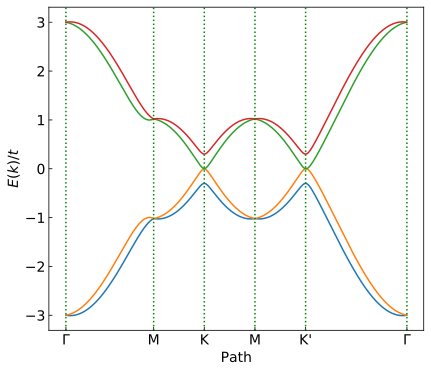

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#     fig.patch.set_facecolor('#000000')
# adjust spacing
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.97, top=0.9, 
                    wspace=0.3, hspace=0.4)
# ax.set_title(r"$\lambda_R=2\Delta_{so}$", fontsize=14)
ax.set_xlabel("Path", fontsize=14)
ax.set_ylabel(r"$E(k)/t$", fontsize=14)
ax.set_xticks(tickpt)
ax.set_xticklabels(ptname)
ax.tick_params(axis='both', direction='in', labelsize=14)

for band in range(Edata.shape[1]):
    ydata = Edata[:, band]
    ax.plot(xdata, ydata)

for tick in tickpt:
    ax.axvline(x=tick, color='green', linestyle=':')